---
title: Model generalization
---

In [1]:
%matplotlib ipympl

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from itertools import product
from functools import reduce
import colorspacious

from matplotlib.colors import LinearSegmentedColormap

from ipywidgets import Select, SelectMultiple, IntSlider, ToggleButton, Label, Layout

from IPython.display import display
from ipywidgets import HBox, VBox

plt.rcParams["legend.frameon"] = False
plt.rcParams["legend.fontsize"] = 8
plt.rcParams["legend.title_fontsize"] = 8
plt.rcParams["xtick.labelsize"] = 8
plt.rcParams["ytick.labelsize"] = 8

In [2]:
def reduction(series, mode):
    match mode:
        case "mean":
            return series.mean()
        case "min":
            return series.min()
        
        case "max":
            return series.max()
        case "median":
            return series.median()
        case _:
            return ValueError


def n_image_select():
    return SelectMultiple(
        options=[64, 128, 256, 512],
        value=[64, 128, 256, 512],
        rows=4,
        # description="Number of training images",
        disabled=False,
        layout={"width": "100px", "height":"88px"},
    )


def pretrain_lr_select():
    return SelectMultiple(
        options=["1e-3", "1e-4"],
        value=["1e-3", "1e-4"],
        rows=2,
        # description="Pretrain LRs",
        disabled=False,
        layout={"width": "100px"},
    )


def transfer_lr_select():
    return SelectMultiple(
        options=["1e-4", "1e-5"],
        value=["1e-4", "1e-5"],
        rows=2,
        # description="Transfer LRs",
        disabled=False,
        layout={"width": "100px"},
    )


def weight_freezing_select():
    return SelectMultiple(
        options=["none", "decoder", "encoder"],
        value=["none", "decoder", "encoder"],
        # description="Weight freezing",
        rows=3,
        disabled=False,
        layout={"width": "100px"},
    )


def reduction_select():
    return Select(
        options=["min", "mean", "median", "max"],
        value="mean",
        rows=4,
        # description="Data Reduction",
        disabled=False,
        layout={"width": "100px"},
    )


def transform(c, s, l):
    res = colorspacious.cspace_convert(c[:3], "sRGB1", "JCh")

    res[0] *= l
    res[1] *= s

    return colorspacious.cspace_convert(res, "JCh", "sRGB1")


def normalize_endpoints(cmin, cmax, J, C):
    cmin = colorspacious.cspace_convert(cmin[:3], "sRGB1", "JCh")
    cmax = colorspacious.cspace_convert(cmax[:3], "sRGB1", "JCh")

    cmin[0], cmax[0] = J, J
    cmin[1], cmax[1] = C, C

    cmin = colorspacious.cspace_convert(cmin, "JCh", "sRGB1")
    cmax = colorspacious.cspace_convert(cmax, "JCh", "sRGB1")

    return cmin, cmax


def get_diverging_colormap():
    dmap_endpoint = sns.diverging_palette(250, 30, l=60, s=100, center="dark", sep=1, as_cmap=True)
    color_min = dmap_endpoint(0)
    color_max = dmap_endpoint(255)

    color_min, color_max = normalize_endpoints(color_min, color_max, 50, 70)

    L = 1.68
    S = 2.5e-3
    N = 256
    cleft = [
        transform(color_min, s, l) for s, l in zip(1 - np.geomspace(S, 1, N), np.linspace(1, L, N))
    ]
    cright = [
        transform(color_max, s, l) for s, l in zip(1 - np.geomspace(1, S, N), np.linspace(L, 1, N))
    ]
    cleft[0] = color_min
    cright[-1] = color_max

    dmap = LinearSegmentedColormap.from_list(
        "cmap_name",
        # [color_min, color_center, color_max]
        np.clip(cleft + cright, 0, 1),
        1024,
    )

    return dmap

In [3]:
with open("mini_df.pkl", "rb") as f:
    df = pickle.load(f)

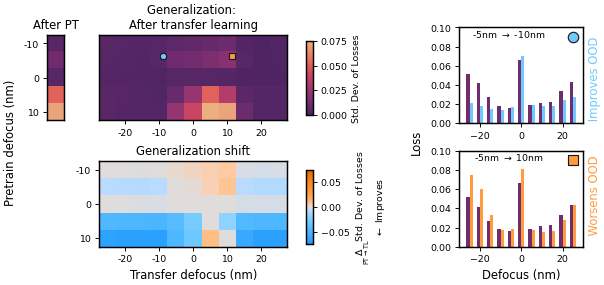

In [6]:
# | label: app:gen_widget


def get_heatmap_data(df, reduction_mode, filter_zero):
    all_defoci = np.arange(-250, 300, 50)
    if filter_zero:
        defoci_set = set(all_defoci).difference([0.0])
    else:
        defoci_set = set(all_defoci)

    p_heatmap = np.zeros((5, 11))
    t_heatmap = np.zeros((5, 11))
    pg_heatmap = np.zeros((5, 11))
    tg_heatmap = np.zeros((5, 11))

    common_defoci = [-100, -50, 0, 50, 100]
    all_defoci = np.arange(-250, 300, 50)
    for i, starting_df in enumerate(common_defoci):
        p_df = df.query(f"pretrain_defocus == {starting_df}")
        pg_heatmap[i, :] = np.std(
            [reduction(p_df[f"best_pretrain_val_{p}"], reduction_mode) for p in defoci_set]
        )
        for j, transfer_df in enumerate(all_defoci):
            p_heatmap[i, j] = reduction(
                p_df[f"best_pretrain_val_{transfer_df}"], reduction_mode
            )
            t_df = p_df.query(f"transfer_defocus=={transfer_df}")
            tg_heatmap[i, j] = np.std(
                [
                    reduction(t_df[f"best_transfer_performance_{p}"], reduction_mode)
                    for p in defoci_set
                ]
            )

            if len(t_df) > 0:
                t_heatmap[i, j] = reduction(
                    t_df[f"best_transfer_performance_{transfer_df}"], reduction_mode
                )
            else:
                t_heatmap[i, j] = p_heatmap[i, j]
                tg_heatmap[i, j] = pg_heatmap[i, j]

    return p_heatmap, t_heatmap, pg_heatmap, tg_heatmap


def plot_bars(
    df,
    tg_heatmap,
    p_heatmap,
    pg_heatmap,
    marker_pairs,
    bar_axes,
    heatmap_axis,
    reduction_mode,
    gmax,
    smax,
):
    all_defoci = np.arange(-250, 300, 50)
    pmap = {k: v for k, v in zip(np.arange(-100, 150, 50), range(5))}
    tmap = {k: v for k, v in zip(np.arange(-250, 300, 50), range(11))}
    res_markers = []
    for df_pair, ax, marker in zip(marker_pairs, bar_axes, ("o", "s")):
        bar_pdf, bar_tdf = df_pair
        p_idx, t_idx = pmap[bar_pdf], tmap[bar_tdf]

        r_df = df.query(f"pretrain_defocus == {bar_pdf} and transfer_defocus == {bar_tdf}")
        tbars = [
            reduction(r_df[f"best_transfer_performance_{p}"], reduction_mode) for p in all_defoci
        ]

        c = cmap(pg_heatmap[p_idx, t_idx] / gmax)
        ax.bar((all_defoci - 15) / 10, p_heatmap[p_idx, :], color=c, width=1.5, align="edge")

        shift_val = tg_heatmap[p_idx, t_idx] - pg_heatmap[p_idx, t_idx]
        if (abs(shift_val) / smax) < 0.2:
            c = dmap(0.7) if np.sign(shift_val) == 1 else dmap(0.3)
        else:
            c = dmap(((shift_val) / smax) / 2 + 0.5)

        ax.bar(all_defoci / 10, tbars, width=1.5, color=c, align="edge")

        ## Add markers to heat maps
        heatmap_axis.scatter(
            t_idx + 0.25, p_idx - 0.25, s=30, marker=marker, color=c, edgecolors=(0.1, 0.1, 0.1)
        )
        ax.text(
            # -10,
            # 0.09,
            0.4,
            0.9,
            f"{df_pair[0] // 10}nm $\\rightarrow$ {df_pair[1] // 10}nm",
            fontsize=8,
            ha="center",
            transform=ax.transAxes,
        )


        if df_pair[0] == df_pair[1]:
            ax.text(0.4, 0.8, "Choose new pair!", fontsize=6, ha="center", color=(0.8, 0.1, 0.0), transform=ax.transAxes,)
        else:
            c = dmap(0.7) if np.sign(shift_val) == 1 else dmap(0.3)
            style = {
               'x':32.5,
                'y':ax.get_ylim()[1]/2,
                'rotation':90,
                'ha':'left',
                'va':'center',
                'color':c,
            }
            if shift_val < 0:
                # ax.text(32.5, ax.get_ylim()[1]/2, 'Improves OOD', rotation=90, ha='center', va='center', color=c)
                ax.text(s='     Improves OOD', **style)
            else:
                ax.text(s='      Worsens OOD', **style)
    
                
        res_markers.append({'s':80, 'marker':marker, 'color':c, 'edgecolors':(0.1, 0.1, 0.1)})

    return res_markers
        


### Interactive setttings

### Visualization settings
cmap = sns.color_palette("flare_r", as_cmap=True)
dmap = get_diverging_colormap()

filter_zero = True
gmin = 0.0
gmax = 7.5e-2 
smax = 7.5e-2

### Figure set up
dpi = 100

# ratio = 2.1
# height = 3.4
# width = ratio * height
width = 7.2
height = 3.4
dpi = 84

fig_style = {
    "figsize": (width, height),  # inches
    "constrained_layout": True,
    "dpi":dpi,
}

fig = plt.figure(**fig_style)
gs = fig.add_gridspec(2, 12, wspace=0.1)

fig_ptgen = fig.add_subfigure(gs[:, :6])
gen_gs = fig_ptgen.add_gridspec(2, 12)
ax_pgen = fig_ptgen.add_subplot(gen_gs[0, 0])
ax_tgen = fig_ptgen.add_subplot(gen_gs[0, 1:])
ax_gen_shift = fig_ptgen.add_subplot(gen_gs[1, 1:])

fig_bars = fig.add_subfigure(gs[:, 8:])
bars_gs = fig_bars.add_gridspec(2, 1)
ax_circ = fig_bars.add_subplot(bars_gs[0])
ax_square = fig_bars.add_subplot(bars_gs[1])

fig_cbars = fig.add_subfigure(gs[:, 6:8])
cbars_gs = fig_cbars.add_gridspec(100, 8)
ax_gen_cbar = fig_cbars.add_subplot(cbars_gs[8:38, 0:3])
ax_shift_cbar = fig_cbars.add_subplot(cbars_gs[55:85, 0:3])


ndata_select = n_image_select()
ptlr_select = pretrain_lr_select()
tllr_select = transfer_lr_select()
freeze_select = weight_freezing_select()
rmode_select = reduction_select()
filter_zero_button = ToggleButton(
    value=True, description="Filter zero defocus", style={'font_size':'8pt'}, layout={'width':'125px'},
)

sq_ptdf_slider = IntSlider(
    value=-5,
    min=-10,
    max=10,
    step=5,
    # description="(Square) Pretrain defocus (nm):",
    disabled=False,
    continuous_update=False,
    orientation="horizontal",
    readout=True,
    readout_format="d",
    layout={'width':'150px'}
)

sq_tldf_slider = IntSlider(
    value=10,
    min=-25,
    max=25,
    step=5,
    # description="(Square) Transfer defocus (nm):",
    disabled=False,
    continuous_update=False,
    orientation="horizontal",
    readout=True,
    readout_format="d",
    layout={'width':'250px'}
)

cr_ptdf_slider = IntSlider(
    value=-5,
    min=-10,
    max=10,
    step=5,
    # description=" Pretrain defocus (nm):",
    disabled=False,
    continuous_update=False,
    orientation="horizontal",
    readout=True,
    readout_format="d",
    layout={'width':'150px'}
)

cr_tldf_slider = IntSlider(
    value=-10,
    min=-25,
    max=25,
    step=5,
    # description="Transfer defocus (nm):",
    disabled=False,
    continuous_update=False,
    orientation="horizontal",
    readout=True,
    readout_format="d",
    layout={'width':'250px'}
)

center_align = Layout(align_items="center")  # , width='50%')

small_font = {'font_size':'8pt'}
sq_slider_box = VBox(
    [
        Label("Adjust square marker"),
        Label("Pretrain defocus (nm)", style=small_font),
        sq_ptdf_slider,
        Label("Transfer defocus (nm)", style=small_font),
        sq_tldf_slider,
    ],
    layout=center_align,
)

cr_slider_box = VBox(
    [
        Label("Adjust circle marker"),
        Label("Pretrain defocus (nm)", style=small_font),
        cr_ptdf_slider,
        Label("Transfer defocus (nm)", style=small_font),
        cr_tldf_slider,
    ],
    layout=center_align,
)



ptlr_box = VBox([Label("Pretrain LR"), ptlr_select], layout=center_align)
tllr_box = VBox([Label("Transfer LR"), tllr_select], layout=center_align)
ndata_box = VBox([Label("# of training images"), ndata_select], layout=center_align)
freeze_box = VBox([Label("Weight Freezing"), freeze_select], layout=center_align)
rmode_box = VBox([Label("Data reduction"), rmode_select, filter_zero_button], layout={'align_items':'center', 'width':'150px'})

left_box = VBox([ndata_box, freeze_box], layout={'align_items':'center', 'width':'150px'})
right_box = VBox(
    [
        ptlr_box,
        tllr_box,
    ],
    layout={'align_items':'center', 'width':'150px'},
)

menu_box = HBox([left_box, right_box, rmode_box])


slider_box = HBox([cr_slider_box, sq_slider_box])

full_box = VBox([menu_box, slider_box], )

display(full_box)


def update_plot(*args):
    filter_zero = filter_zero_button.value
    N_points = ndata_select.value
    weight_freezing = freeze_select.value
    pretrain_lrs = ptlr_select.value
    transfer_lrs = tllr_select.value
    reduction_mode = rmode_select.value
    active_lr_pairs = tuple(product(pretrain_lrs, transfer_lrs))

    marker_pairs = [  # Point and click
        (cr_ptdf_slider.value*10, cr_tldf_slider.value*10),
        (sq_ptdf_slider.value*10, sq_tldf_slider.value*10),
    ]

    lr_query = reduce(
        lambda x, y: f"{x} or {y}",
        (f"(pretrain_lr == {x} and transfer_lr == {y})" for x, y in active_lr_pairs),
    )

    plot_df = df.query(
        f"N_tl_training_points in {N_points} and freeze_option in {weight_freezing}"
    ).query(lr_query)

    p_heatmap, _, pg_heatmap, tg_heatmap = get_heatmap_data(plot_df, reduction_mode, filter_zero)

    ### Plotting
    ax_tgen.clear()

    gen_cim = ax_pgen.matshow(pg_heatmap[:, 0][:, None], cmap=cmap, vmin=gmin, vmax=gmax)
    ax_tgen.matshow(tg_heatmap, cmap=cmap, vmin=gmin, vmax=gmax)
    shift_cim = ax_gen_shift.matshow(
        tg_heatmap - pg_heatmap,
        cmap=dmap,
        vmin=-smax,
        vmax=smax,
    )
    tc = fig.colorbar(gen_cim, cax=ax_gen_cbar, aspect=1)
    fig.colorbar(shift_cim, cax=ax_shift_cbar)

    ax_circ.clear()
    ax_square.clear()
    res_markers = plot_bars(
        df,
        tg_heatmap,
        p_heatmap,
        pg_heatmap,
        marker_pairs,
        (ax_circ, ax_square),
        ax_tgen,
        reduction_mode,
        gmax,
        smax,
    )

    ### Formatting
    for ax in [ax_tgen, ax_gen_shift]:
        ax.set_xticks([1, 3, 5, 7, 9])
        ax.set_xticklabels([-20, -10, 0, 10, 20], rotation=0, fontsize=8)
        ax.xaxis.set_ticks_position("bottom")

    for ax in [ax_pgen, ax_gen_shift]:
        ax.set_yticks([0, 2, 4])
        ax.set_yticklabels([-10, 0, 10], fontsize=8)

    for ax, pair, marker in zip([ax_circ, ax_square], marker_pairs, res_markers):
        pt_df = pair[0] / 10
        if pt_df < 5:
            ax.set_ylim([0, 0.1])
            sy = 0.09
        elif pt_df == 5:
            ax.set_ylim([0, 0.2])
            sy = 0.18
        elif pt_df == 10:
            ax.set_ylim([0, 0.3])
            sy = 0.27
        ax.set_xlim([-30, 30])
        ax.scatter(25, sy, **marker)

            


    ax_pgen.set_xticks([])
    ax_tgen.set_yticks([])

    ax_tgen.set_title("Generalization: \nAfter transfer learning", fontsize=10)
    ax_gen_shift.set_title("Generalization shift", fontsize=10)
    ax_pgen.set_title("After PT", fontsize=10)

    fig_ptgen.supylabel("Pretrain defocus (nm)", fontsize=10)
    fig_bars.supylabel("Loss", fontsize=10)
    fig_bars.suptitle(" ")
    ax_square.set_xlabel("Defocus (nm)", fontsize=10)
    ax_gen_shift.set_xlabel("Transfer defocus (nm)", fontsize=10)
    ax_gen_cbar.set_ylabel("Std. Dev. of Losses", fontsize=8, x=0.65)
    ax_gen_cbar.set_title(" ")
    ax_shift_cbar.set_ylabel(r"$\underset{\text{PT} \rightarrow \text{TL}}{\Delta}$Std. Dev. of Losses"  + "\n" + r"$\leftarrow$ Improves", fontsize=8, x=0.65)
    # ax_shift_cbar.set_ylabel("Std. Dev. of Losses", fontsize=8, x=0.65)
    # ax_shift_cbar.set_title(" ")
                             
                            
    # ax_shift_cbar.text(0, -0.1, 'Improves', fontsize=8, va='top')
    # ax_shift_cbar.text(0, 0.1, 'Worsens', fontsize=8, va='bottom',)
    
    _ = [
        plt.setp(ax.spines.values(), linewidth=1.25)
        for ax in (
            ax_pgen,
            ax_tgen,
            ax_gen_shift,
            ax_circ,
            ax_square,
            ax_gen_cbar,
            ax_shift_cbar,
        )
    ]

update_plot()
ndata_select.observe(update_plot, "value")
ptlr_select.observe(update_plot, "value")
tllr_select.observe(update_plot, "value")
rmode_select.observe(update_plot, "value")
freeze_select.observe(update_plot, "value")
filter_zero_button.observe(update_plot, "value")
sq_ptdf_slider.observe(update_plot, "value")
sq_tldf_slider.observe(update_plot, "value")
cr_ptdf_slider.observe(update_plot, "value")
cr_tldf_slider.observe(update_plot, "value")